<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PlotEnergies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packaages

In [49]:
%%capture
import sys
# install jscatter as user in the current Jupyter kernel
!{sys.executable} -m pip install jscatter
!{sys.executable} -m pip install ipympl

# Import libraries

In [3]:
%matplotlib ipympl

import jscatter as js
import matplotlib.pyplot as plt
import os 
import numpy as np
from google.colab import output


js.usempl(True)  # use matplotlib
#js.usempl(False) # default, use grace on your computer with xmgrace in external window.


output.enable_custom_widget_manager()

Using  mpl


# Import Files

In [4]:
#@title Import files from google
#from google.colab import drive

#drive.flush_and_unmount()
#drive.mount('/content/drive', force_remount=False)

In [17]:
#@title Github

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI


Cloning into 'MD-SCPI'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 612 (delta 59), reused 58 (delta 38), pack-reused 497
Receiving objects: 100% (612/612), 171.37 MiB | 26.86 MiB/s, done.
Resolving deltas: 100% (289/289), done.


In [46]:
work_directory_AS4 = '/content/MD-SCPI/PDBs/MD/AS4' #'/content/drive/MyDrive/MolecularDynamics_2023/USP/AS4/Energies'
work_directory_COL = '/content/MD-SCPI/PDBs/MD/COL' #'/content/drive/MyDrive/MolecularDynamics_2023/USP/COL/Energies'

files = os.listdir(work_directory_AS4)
ligand_files = np.array([file for file in files if 'ligand' in file])
[print(i, ligand_files[i]) for i in range(ligand_files.size)];
ligand_files_interesting = ligand_files[[1,8,6,7,9]]

dt = 0.002*1e3 # ste time in ns

0 ligand-HH22.dat
1 ligand-protein.dat
2 ligand-solvent.dat
3 ligand-THR220.dat
4 ligand-SER85.dat
5 ligand-GLN51.dat
6 ligand-env.dat
7 ligand-ASN45.dat
8 ligand-SER118.dat
9 ligand-ARG92.dat


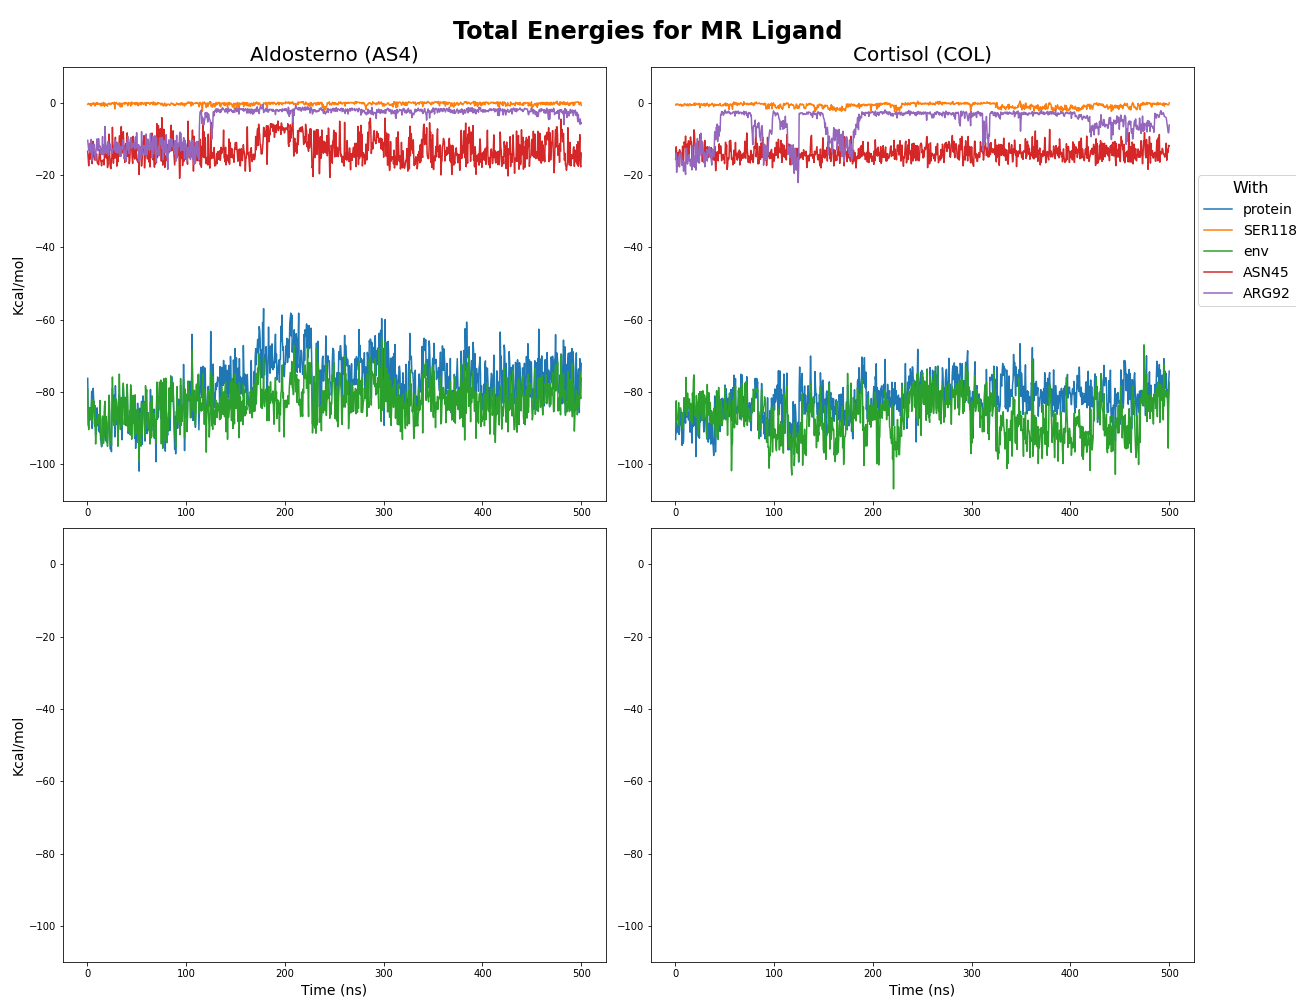

In [56]:
plt.close()
fig, axs = plt.subplots(2,2,figsize=(18,14))

# -------------- aldosterone -------------------------
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
  axs[0,0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

#axs[0,0].set_xlabel('Time (ns)', fontsize='14')
axs[0,0].set_ylabel('Kcal/mol', fontsize='14')
axs[0,0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
axs[0,0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

# ------------------ cortisol --------------------------
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
  axs[0,1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

#axs[0,1].set_xlabel('Time (ns)', fontsize='14')
#axs[0,1].set_ylabel('Kcal/mol', fontsize='14')
legend = axs[0,1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
axs[0,1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
#axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

axs[0,1].sharey(axs[0,0]); axs[0,1].sharex(axs[0,0]) # share x and y axis
axs[1,0].sharey(axs[0,0]); axs[1,0].sharex(axs[0,0])
axs[1,1].sharey(axs[0,0]); axs[1,1].sharex(axs[0,0])

#plt.rcParams['legend.title_fontweight'] = 'bold'


axs[1,0].set_xlabel('Time (ns)', fontsize='14')
axs[1,1].set_xlabel('Time (ns)', fontsize='14')
axs[1,0].set_ylabel('Kcal/mol', fontsize='14')

# axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
fig.tight_layout()
plt.show()

In [48]:
interaction = 'ligand-ASN45.dat'

def PlotAllEnergies(interaction):
  data=js.dA(os.path.join(work_directory_AS4, interaction), ignore='#')

  fig = plt.figure(figsize=(11,6))
  plt.plot(data.X, data.Y, label='Elec')
  plt.plot(data.X, data.eY, label="VDW")
  plt.plot(data.X, data.Y + data.eY, label='Total')
  plt.xlabel('Frame'); plt.ylabel('K Cal')
  plt.legend(bbox_to_anchor=(1.05, .5), title='Energy0')
  plt.title('Energies of ligand-ASN45.dat', fontweight='bold', fontsize='18')
  
  plt.show()

  return fig

In [ ]:
#help(data)

In [ ]:
#p=js.mplot()
#p.plot(data)